<a href="https://colab.research.google.com/github/jeffheaton/app_generative_ai/blob/main/t81_559_class_02_4_software_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-559: Applications of Generative Artificial Intelligence
**Module 2: Code Generation**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 2 Material

* Part 2.1: Prompting for Code Generation [[Video]](https://www.youtube.com/watch?v=HVId6kYKKgQ) [[Notebook]](t81_559_class_02_1_dev.ipynb)
* Part 2.2: Handling Revision Prompts [[Video]](https://www.youtube.com/watch?v=APpV46tplXA) [[Notebook]](t81_559_class_02_2_multi_prompt.ipynb)
* Part 2.3: Using a LLM to Help Debug [[Video]](https://www.youtube.com/watch?v=VPqSNb38QK0) [[Notebook]](t81_559_class_02_3_llm_debug.ipynb)
* **Part 2.4: Tracking Prompts in Software Development** [[Video]](https://www.youtube.com/watch?v=oUFUuYfvXZU) [[Notebook]](t81_559_class_02_4_software_eng.ipynb)
* Part 2.5: Limits of LLM Code Generation [[Video]](https://www.youtube.com/watch?v=dKtRI0LZSyY) [[Notebook]](t81_559_class_02_5_code_gen_limits.ipynb)


# Google CoLab Instructions

The following code ensures that Google CoLab is running and maps Google Drive if needed.

In [7]:
import os

try:
    from google.colab import drive, userdata
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# OpenAI Secrets
if COLAB:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# Install needed libraries in CoLab
if COLAB:
    !pip install langchain langchain_openai

Note: using Google CoLab


# 2.4: Tracking Prompts in Software Development

Prompting will undoubtedly become an essential part of modern software engineering. Programmers will likely construct individual prompts to generate methods. In this part, we will see how to write a prompt that consistently produces a non-trivial image cropping function. We will also store the prompt with the function so we do not lose the prompt in the future. Additionally, we will use automated unit tests to ensure that the generated method initially does what we expect, and continues to do so in the future, even if the technique is regenerated.

## Conversational Code Generation

We will continue to use the conversational code generation function provided in Module 2.2.



In [8]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.chat_history import InMemoryChatMessageHistory
from IPython.display import display_markdown

MODEL = "gpt-5-mini"
SYSTEM_TEMPLATE = """The following is a friendly conversation between a human and an
AI to generate Python code. If you have notes about the code, place them before
the code. Any notes about execution should follow the code. If you do mix any
notes with the code, make them comments. Add proper comments to the code.
Sort imports and follow PEP 8 formatting.
"""

_histories = {}
def _get_history(session_id: str):
    return _histories.setdefault(session_id, InMemoryChatMessageHistory())

def _build_chain():
    llm = ChatOpenAI(model=MODEL, temperature=0.0, n=1)
    prompt = ChatPromptTemplate.from_messages([
        ("system", SYSTEM_TEMPLATE),
        MessagesPlaceholder("history"),
        ("human", "{input}")
    ])
    return prompt | llm | StrOutputParser()

def start_conversation(session_id: str = "default"):
    base = _build_chain()
    with_history = RunnableWithMessageHistory(
        base,
        lambda sid: _get_history(sid),
        input_messages_key="input",
        history_messages_key="history",
    )
    # Return a runnable pre-bound to the session id
    return with_history.with_config(configurable={"session_id": session_id})

def generate_code(conversation, prompt: str):
    print("Model response:")
    result = conversation.invoke({"input": prompt})
    display_markdown(result, raw=True)
    return result

# Usage:
# conversation = start_conversation()  # or start_conversation("my-session")
# generate_code(conversation, "Write a function to compute Levenshtein distance.")

## Prompts for Consistent Code Generation

The code below shows the prompt I created to generate the clipping function. It is essential to specify very clearly what you want from the LLM. In this case, I made sure to specify:

* The name of the function
* The name of all arguments to that function
* What to return
* The exact algorithm, including how to handle negative values


In [9]:
conversation = start_conversation()
generate_code(conversation,"""
Write a Python function named safe_clip using the PEP-8 style guide. The function
should accept five parameters: cv2_image, x, y, width, height, and background.
The imports should be sorted alphabetically.

The purpose of this function is to clip a region from an OpenCV image while a
djusting for boundaries and filling any areas missing from the original image
boundaries with a specified color. Ensure that the code includes comments and a
docstring explaining the functionality in detail.

The function should:

Calculate the dimensions of the clipping region and adjust them if they extend
beyond the image boundaries. Negative x and y indicate that the source image
must be expanded to accomodate the these coordinate that were outside the image.
Create a new image of the specified size, filled with the background color.
Place the clipped region into the newly created image at the appropriate location.
Return a tuple containing the new image, along with x and y offsets indicating
how much the origin of the clipped image has shifted relative to the original image.
The return type should be specified in the function's docstring, which should
also detail the types and purposes of each parameter. Additionally, mention that
the function will adjust coordinates and size to fit within the image dimensions and
fill missing areas with the specified background color.

Include a detailed example in the docstring illustrating how the function is
called and what it returns.
""")

Model response:


Notes:
- The function below uses OpenCV (cv2) and NumPy. Ensure these are installed in your environment.
- The code follows PEP 8 style, includes comments, and a detailed docstring with an example.

```python
import cv2
import numpy as np
from typing import Tuple


def safe_clip(
    cv2_image: np.ndarray,
    x: int,
    y: int,
    width: int,
    height: int,
    background
) -> Tuple[np.ndarray, int, int]:
    """
    Clip a rectangular region from an OpenCV image while safely handling
    out-of-bounds coordinates and filling any missing areas with a
    background color.

    Parameters
    ----------
    cv2_image : np.ndarray
        Source OpenCV image (H x W or H x W x C). The image can be single
        channel (grayscale) or multi-channel (e.g., BGR).
    x : int
        X-coordinate (column) of the top-left corner of the requested clip
        relative to the source image. Can be negative.
    y : int
        Y-coordinate (row) of the top-left corner of the requested clip
        relative to the source image. Can be negative.
    width : int
        Width of the clipping area in pixels. Must be positive.
    height : int
        Height of the clipping area in pixels. Must be positive.
    background : int or tuple
        Background color used to fill areas outside the source image.
        If the image has multiple channels, provide a tuple with one value
        per channel (e.g., (B, G, R)). A single scalar will be broadcasted
        to all channels.

    Returns
    -------
    tuple (np.ndarray, int, int)
        - new_image: np.ndarray
            The resulting clipped image of size (height, width) or
            (height, width, C), filled with the background color where the
            source image did not provide pixels.
        - x_offset: int
            How much the origin of the clipped image has shifted in X
            relative to the original image. This is the amount the source
            content was moved right within the returned image. For example,
            if x was -10, x_offset will be 10.
        - y_offset: int
            How much the origin of the clipped image has shifted in Y
            relative to the original image. This is the amount the source
            content was moved down within the returned image.

    Notes
    -----
    - The function adjusts coordinates and size to fit within the image
      dimensions. Areas requested outside the source image are filled with
      the provided background color.
    - Negative x or y effectively expands the source coordinate origin so the
      returned image contains the requested region with the original image
      positioned appropriately inside.

    Example
    -------
    >>> import numpy as np
    >>> import cv2
    >>> # Create a 100x100 blue BGR image
    >>> src = np.full((100, 100, 3), (255, 0, 0), dtype=np.uint8)
    >>> # Request a 50x50 region starting at x=-10, y=20, using gray background
    >>> clipped, x_off, y_off = safe_clip(src, x=-10, y=20, width=50,
    ...                                  height=50, background=(128, 128, 128))
    >>> clipped.shape
    (50, 50, 3)
    >>> x_off, y_off
    (10, 0)
    >>> # The original content appears starting at column 10 in clipped.
    """
    # Validate width and height
    if width <= 0 or height <= 0:
        raise ValueError("width and height must be positive integers")

    # Determine source image dimensions and number of channels
    if cv2_image.ndim == 2:
        src_h, src_w = cv2_image.shape
        channels = 1
    elif cv2_image.ndim == 3:
        src_h, src_w, channels = cv2_image.shape
    else:
        raise ValueError("cv2_image must be a 2D or 3D numpy array")

    # Create output image filled with the background color
    # Ensure background matches the number of channels
    if channels == 1:
        # Single channel: create 2D array
        new_img = np.full((height, width), background, dtype=cv2_image.dtype)
    else:
        # Multi-channel: broadcast scalar background or validate tuple length
        if np.isscalar(background):
            bg = [background] * channels
        else:
            bg = list(background)
            if len(bg) != channels:
                raise ValueError(
                    "Length of background tuple must match number of image channels"
                )
        new_img = np.full((height, width, channels), bg, dtype=cv2_image.dtype)

    # Compute overlapping region between requested rectangle and source image
    src_x1 = max(x, 0)
    src_y1 = max(y, 0)
    src_x2 = min(x + width, src_w)
    src_y2 = min(y + height, src_h)

    # If there is no overlap, return the background-filled image and offsets
    if src_x1 >= src_x2 or src_y1 >= src_y2:
        x_offset = -min(x, 0)
        y_offset = -min(y, 0)
        return new_img, x_offset, y_offset

    # Destination coordinates in the new image where source pixels will be placed
    dst_x1 = src_x1 - x
    dst_y1 = src_y1 - y
    dst_x2 = dst_x1 + (src_x2 - src_x1)
    dst_y2 = dst_y1 + (src_y2 - src_y1)

    # Copy the overlapping region from source into the destination image
    if channels == 1:
        new_img[dst_y1:dst_y2, dst_x1:dst_x2] = cv2_image[src_y1:src_y2, src_x1:src_x2]
    else:
        new_img[dst_y1:dst_y2, dst_x1:dst_x2, :] = cv2_image[
            src_y1:src_y2, src_x1:src_x2, :
        ]

    # Offsets indicate the shift of the original requested origin inside new_img
    x_offset = dst_x1
    y_offset = dst_y1

    return new_img, x_offset, y_offset
```

Execution notes:
- Requires OpenCV (cv2) and NumPy installed (e.g., pip install opencv-python numpy).
- The function accepts BGR images (default OpenCV color order). If you work with other
  color orders, handle conversions before or after calling safe_clip.

'Notes:\n- The function below uses OpenCV (cv2) and NumPy. Ensure these are installed in your environment.\n- The code follows PEP 8 style, includes comments, and a detailed docstring with an example.\n\n```python\nimport cv2\nimport numpy as np\nfrom typing import Tuple\n\n\ndef safe_clip(\n    cv2_image: np.ndarray,\n    x: int,\n    y: int,\n    width: int,\n    height: int,\n    background\n) -> Tuple[np.ndarray, int, int]:\n    """\n    Clip a rectangular region from an OpenCV image while safely handling\n    out-of-bounds coordinates and filling any missing areas with a\n    background color.\n\n    Parameters\n    ----------\n    cv2_image : np.ndarray\n        Source OpenCV image (H x W or H x W x C). The image can be single\n        channel (grayscale) or multi-channel (e.g., BGR).\n    x : int\n        X-coordinate (column) of the top-left corner of the requested clip\n        relative to the source image. Can be negative.\n    y : int\n        Y-coordinate (row) of the top-l

## Trying Out the Generated Code

The code below shows the prompt I created to generate the clipping function. It is essential to specify very clearly what you want from the LLM. In this case, I made sure to specify:

* The name of the function
* The name of all arguments to that function
* What to return
* The exact algorithm, including how to handle negative values

The following code shows my function; I also embed the prompt inside the source as a comment. This way, I can track changes to both the function and prompt as I check both in a source code repository like GitHub.

In [10]:
import numpy as np

## safe_clip was generated by the following prompt:
# Write a Python function named safe_clip using the PEP-8 style guide. The function
# should accept five parameters: cv2_image, x, y, width, height, and background.
# The imports should be sorted alphabetically.
#
# The purpose of this function is to clip a region from an OpenCV image while a
# djusting for boundaries and filling any areas missing from the original image
# boundaries with a specified color. Ensure that the code includes comments and a
# docstring explaining the functionality in detail.
#
# The function should:
#
# Calculate the dimensions of the clipping region and adjust them if they extend
# beyond the image boundaries. Negative x and y indicate that the source image
# must be expanded to accomodate the these coordinate that were outside the image.
# Create a new image of the specified size, filled with the background color.
# Place the clipped region into the newly created image at the appropriate location.
# Return a tuple containing the new image, along with x and y offsets indicating
# how much the origin of the clipped image has shifted relative to the original image.
# The return type should be specified in the function's docstring, which should
# also detail the types and purposes of each parameter. Additionally, mention that
# the function will adjust coordinates and size to fit within the image dimensions and
# fill missing areas with the specified background color.
#
# Include a detailed example in the docstring illustrating how the function is
# called and what it returns.

def safe_clip(cv2_image, x, y, width, height, background):
    """
    Clips a region from an OpenCV image, adjusting for boundaries and filling missing areas.

    Parameters:
        cv2_image (numpy.ndarray): The source image from which to clip the region.
        x (int): The x-coordinate of the top-left corner of the clipping region.
        y (int): The y-coordinate of the top-left corner of the clipping region.
        width (int): The width of the clipping region.
        height (int): The height of the clipping region.
        background (tuple): A tuple representing the BGR color (e.g., (255, 255, 255) for white) used to fill missing areas.

    Returns:
        tuple: A tuple containing:
            - new_image (numpy.ndarray): The new image with the clipped region and background.
            - x_offset (int): The x-coordinate offset of the new image relative to the original image.
            - y_offset (int): The y-coordinate offset of the new image relative to the original image.

    Example:
        >>> img = np.zeros((100, 100, 3), dtype=np.uint8)
        >>> clipped_img, x_off, y_off = safe_clip(img, -10, -10, 120, 120, (255, 0, 0))
        >>> print(clipped_img.shape, x_off, y_off)
        ((120, 120, 3), 10, 10)
    """
    # Calculate effective x, y, width, and height considering image boundaries
    x_eff = max(x, 0)
    y_eff = max(y, 0)
    width_eff = min(width, cv2_image.shape[1] - x_eff)
    height_eff = min(height, cv2_image.shape[0] - y_eff)

    # Create a new image filled with the background color
    new_image = np.full((height, width, 3), background, dtype=cv2_image.dtype)

    # Calculate offsets if the requested region is out of the original image bounds
    x_offset = -min(x, 0)
    y_offset = -min(y, 0)

    # Place the clipped part of the original image into the new image
    new_image[y_offset:y_offset + height_eff, x_offset:x_offset + width_eff] = \
        cv2_image[y_eff:y_eff + height_eff, x_eff:x_eff + width_eff]

    return new_image, x_offset, y_offset

Now, I will create an image of a grayscale and show how the function performs on three different types of crops. One of the critical features of this cropping function is that it might expand the original image if the upper-left corner or lower-right corner is off of the original image.

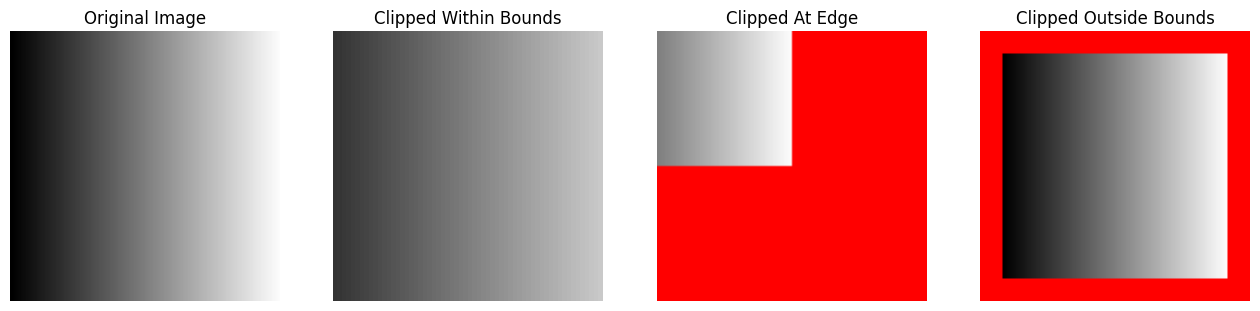

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a demo image (100x100) with a gradient and a solid square in the center
image = np.zeros((100, 100, 3), dtype=np.uint8)
cv2.rectangle(image, (30, 30), (70, 70), (255, 255, 255), -1)  # White square
for i in range(100):
    image[:, i] = i * 2.55  # Gradient from black to white

# Define background color
background_color = (0, 0, 255)  # Red background

# Perform clipping operations
clipped_image_within, _, _ = safe_clip(image, 20, 20, 60, 60, background_color)
clipped_image_edge, _, _ = safe_clip(image, 50, 50, 100, 100, background_color)
clipped_image_outside, _, _ = safe_clip(image, -10, -10, 120, 120, background_color)

# Setup matplotlib plots
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(clipped_image_within, cv2.COLOR_BGR2RGB))
axs[1].set_title('Clipped Within Bounds')
axs[1].axis('off')

axs[2].imshow(cv2.cvtColor(clipped_image_edge, cv2.COLOR_BGR2RGB))
axs[2].set_title('Clipped At Edge')
axs[2].axis('off')

axs[3].imshow(cv2.cvtColor(clipped_image_outside, cv2.COLOR_BGR2RGB))
axs[3].set_title('Clipped Outside Bounds')
axs[3].axis('off')

plt.show()

## Provide Unit Tests

Unit testing is an essential facet of software engineering. Unit testing is necessary when a prompt generates your code. The following code shows how I converted the previous three examples into unit tests.

Most software architects suggest you should not use an LLM to generate the unit tests because you must know what is being tested.

In [13]:
import unittest
import numpy as np
import cv2

class TestSafeClip(unittest.TestCase):

    def setUp(self):
        self.image = np.zeros((100, 100, 3), dtype=np.uint8)
        cv2.rectangle(self.image, (30, 30), (70, 70), (255, 255, 255), -1)
        for i in range(100):
            self.image[:, i] = i * 2.55  # Gradient from black to white
        self.background_color = (0, 0, 255)  # Blue background

    def test_clip_within_bounds(self):
        clipped_image, x_off, y_off = safe_clip(self.image, 20, 20, 60, 60, self.background_color)
        self.assertEqual(clipped_image.shape, (60, 60, 3))
        self.assertEqual((x_off, y_off), (0, 0))
        self.assertTrue((clipped_image[0, 0] != self.background_color).all())

    def test_clip_at_edge(self):
        clipped_image, x_off, y_off = safe_clip(self.image, 50, 50, 100, 100, self.background_color)
        self.assertEqual(clipped_image.shape, (100, 100, 3))
        self.assertEqual((x_off, y_off), (0, 0))
        self.assertTrue((clipped_image[0, 0] == [127, 127, 127]).all())

    def test_clip_outside_bounds(self):
        clipped_image, x_off, y_off = safe_clip(self.image, -10, -10, 120, 120, self.background_color)
        self.assertEqual(clipped_image.shape, (120, 120, 3))
        self.assertEqual((x_off, y_off), (10, 10))
        self.assertTrue((clipped_image[10, 10] == [0, 0, 0]).all())

test = TestSafeClip()
test.setUp()
test.test_clip_within_bounds()
test.test_clip_at_edge()
test.test_clip_outside_bounds()